In [2]:
%%file img2vec.py
# Extract feature vectors of images.
from constant import *
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import sys
import time
import cPickle
import argparse
import math
import copy

#### Parameters ####
parser = argparse.ArgumentParser()
parser.add_argument('--gpu', default=0, required=False)
parser.add_argument('--model_type_str', required=True) # nocrop
parser.add_argument('--model_name', required=True) # 0, all
parser.add_argument('--test_type_str', required=True) # nocrop
parser.add_argument('--test_name', required=True) # 0, 20, 40, 60, 80, 100

args = parser.parse_args()
gpu = int(args.gpu)
model_type_str = args.model_type_str
model_name = args.model_name
test_type_str = args.test_type_str
test_name = args.test_name
'''

gpu = 0
model_type_str = 'nocrop'
model_name = 'all'
test_type_str = 'nocrop'
test_name = '40'
'''

####################

import caffe

caffe.set_device(gpu)
caffe.set_mode_gpu()

print 'Processing: finetune_alexnet_{}_{} on GPU {}, test on {}'.format(model_type_str, model_name, gpu, test_type_str)

test_net = caffe.Net(result_root + 'model/finetune_alexnet_{}_{}/img2vec_{}_{}.prototxt'\
                .format(model_type_str, model_name, test_type_str, test_name),
                result_root + 'model/finetune_alexnet_{}_{}/finetune_alexnet_{}_{}.caffemodel'\
                .format(model_type_str, model_name, model_type_str, model_name),
                caffe.TEST)

transformer = caffe.io.Transformer({'data': test_net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
# Below is the reason of false color: add single color to image, rather than add mean image to image.
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

image_sum = 0
test_file = open('{}dataset/test_{}_{}.txt'.format(imagenet_root, test_type_str, test_name), 'r')
image_sum = len(test_file.readlines())
test_file.close()

vectors = [[] for i in range(len(synset_names))]
# vectors[label] = (vector, predict_id, index_in_lmdb)

start_time = time.time()
for i in range(image_sum):
    test_net.forward()
    label = int(test_net.blobs['label'].data[0])
    vector = copy.copy(test_net.blobs['fc8_occlusion'].data[0])
    index_in_lmdb = i
    predict_id = test_net.blobs['prob'].data[0].argmax()
    
    vectors[label].append((vector, predict_id, index_in_lmdb))
    
    if (i + 1) % 1000 == 0:
        second = int(time.time() - start_time)
        now_time = time.strftime("%H:%M:%S", time.gmtime(second))
        estimated = int(float(image_sum) / (i + 1) * second)
        estimated_time = time.strftime("%H:%M:%S", time.gmtime(estimated))
        print '[{}/{}] {:5}/{:5}: {} {}'.format(now_time, estimated_time, i + 1, image_sum, predict_id, label)
    
    '''
    print label
    print predict_id
    print index_in_lmdb
    print vector
    plt.imshow(transformer.deprocess('data', test_net.blobs['data'].data[0]))
    plt.show()
    break
    '''
with open(result_root + 'img2vec/vectors_{}_{}_{}_{}.pickle'.format(model_type_str, model_name, test_type_str, test_name), 'wb') as f:
    cPickle.dump(vectors, f)
    
print 'done'

Overwriting img2vec.py


47
47
0
[  1.70064306  -3.04564834   0.62833077  -0.80588698   6.25950003
  -1.04495478  -1.98345232  -3.06912541   1.86147916  -2.73364186
  -3.69816518  -1.46121776   0.14168958  -1.1366154   -1.94353807
  -0.62793922  -1.87341285  -0.66383958  -1.46003532  -3.38647318
  -3.04378104  -0.90744895  -2.01692057  -0.93700105  -3.44699931
  -2.76547718  -0.31485793  -1.26789534   0.18268354   1.15312362
  -1.60729015  -3.10514593  -4.29363728   1.28676796  -0.95235091
  -3.30822062  -2.28983235  -2.09296322  -2.63950038  -2.40992832
  -1.52167714   0.92266399   0.16759755   0.80797815   1.46716535
  -0.46496105  -0.8087123   12.73022652   2.09178591  -1.24659181
  -2.79692698  -1.6505059    6.57581091   0.41256496  -0.56506407
  -2.81103563  -0.18802881   1.54600227  -0.85976887   3.49678683
  -2.02093816   4.22216606  -0.21535483   0.14242868  -2.62436438
  -2.38533401   4.87811184  -1.22808158  -3.12012124  -3.22397542
   2.70712876  -0.44722882   2.42806268   4.29818726   1.20059705
  

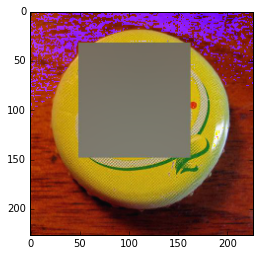

In [58]:
test_net.forward()
label = int(test_net.blobs['label'].data[0])
vector = test_net.blobs['fc8_occlusion'].data[0]
index_in_lmdb = i
predict_id = test_net.blobs['prob'].data[0].argmax()


print label
print predict_id
print index_in_lmdb
print vector
plt.imshow(transformer.deprocess('data', test_net.blobs['data'].data[0]))
plt.show()

In [9]:
# Generate img2vec_{}_{}.prototxt for img2vec.
import os
from constant import *

model_type_strs = ['nocrop', 'crop']
model_names = ['0', 'all']
test_type_strs = ['nocrop', 'crop']
test_names = ['0', '20', '40', '60', '80', '100']

for model_type_str in model_type_strs:
    for model_name in model_names:
        f = open(result_root + 'model/finetune_alexnet_{}_{}/train_val.prototxt'.format(model_type_str, model_name))
        lines = f.readlines()
        f.close()
        for test_type_str in test_type_strs:
            for test_name in test_names:
                lines[34] = '    source: "/data2/haow3/data/imagenet/lmdb/test_{}_{}"\n'.format(test_type_str, test_name)
                lines[35] = '    batch_size: 1\n'
                lines[387] = 'layer {\n'
                lines[388] = '  name: "prob"\n'
                lines[389] = '  type: "Softmax"\n'
                lines[390] = '  bottom: "fc8_occlusion"\n'
                lines[391] = '  top: "prob"\n'
                lines[392] = '}\n'
                lines[393] = ''
                test_file = open(result_root + 'model/finetune_alexnet_{}_{}/img2vec_{}_{}.prototxt'\
                                 .format(model_type_str, model_name, test_type_str, test_name), 'w')
                test_file.writelines(lines)
                test_file.close()
                

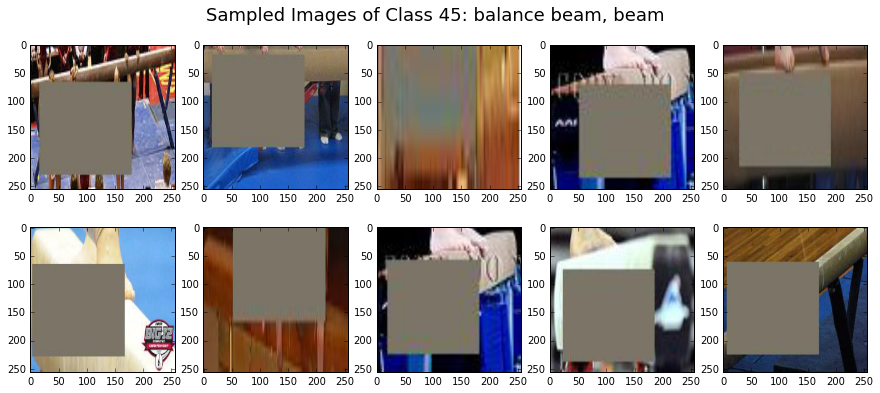

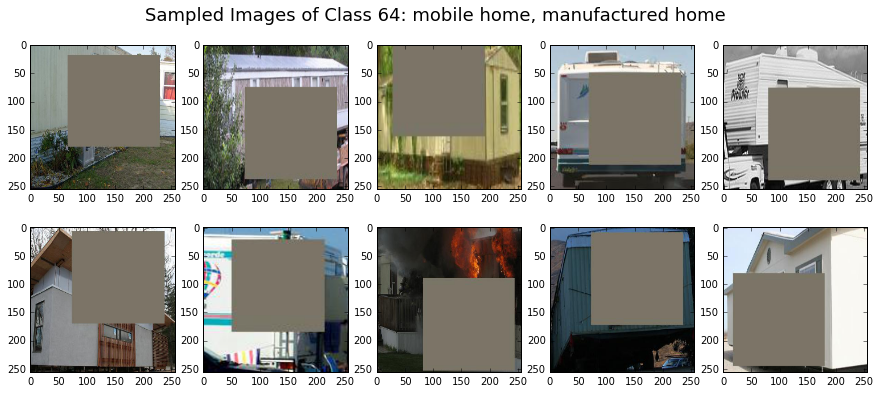

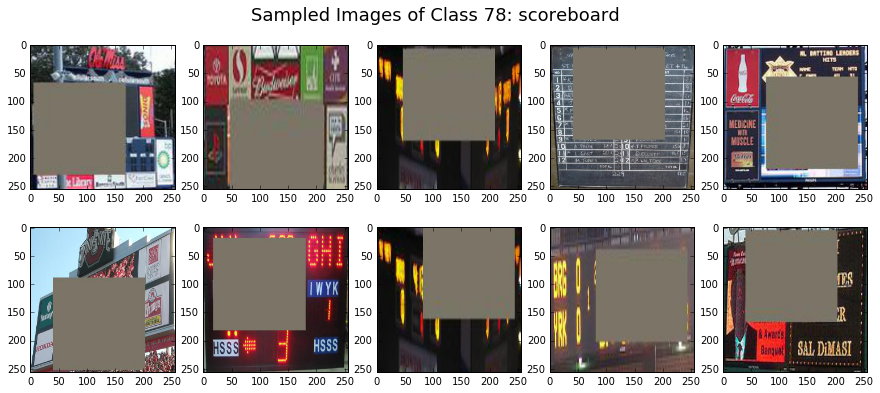

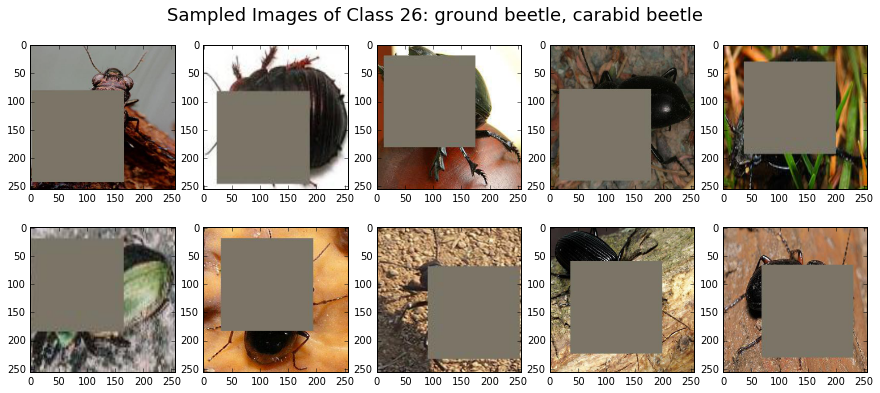

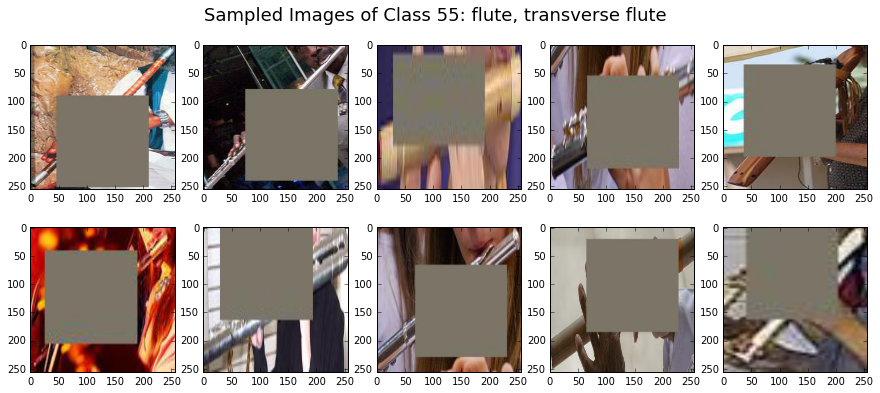

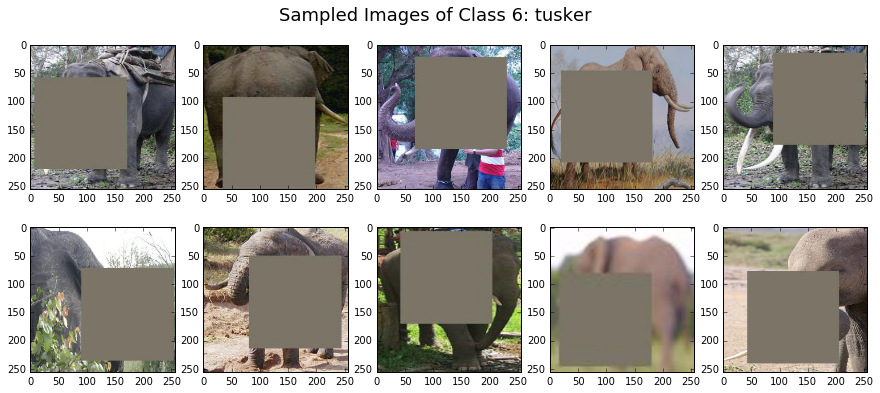

In [33]:
# Show images in lmdb database.

import caffe
import lmdb
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from constant import *

imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
with open(imagenet_labels_filename) as f:
    lines = f.readlines()
new_id_to_name = {}
for original_id, line in enumerate(lines):
    synset_name = line.split(' ')[0]
    name = line[(len(synset_name) + 1):-1]
    if original_id in original_to_new_class_id:
        new_id_to_name[original_to_new_class_id[original_id]] = name


plt.rcParams['figure.figsize'] = (15, 6)

lmdb_env = lmdb.open('/home/haow3/occlusion-project/data/imagenet/lmdb/test_crop_40')
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()
datum = caffe.proto.caffe_pb2.Datum()

target_labels = [45, 64, 78, 26, 55, 6]
images = [[] for i in range(100)]

for target_label in target_labels:
    count = 0
    for key, value in lmdb_cursor:
        datum.ParseFromString(value)
        label = datum.label
        if not target_label == label:
            continue
        data = caffe.io.datum_to_array(datum)
        image_data = [[[0 for i in range(3)] for j in range(256)] for k in range(256)]
        for channel in range(len(data)):
            for x in range(len(data[0])):
                for y in range(len(data[0][0])):
                    image_data[x][y][2 - channel] = data[channel][x][y]
        images[target_label].append(copy.copy(image_data))
        count += 1
        if count == 10:
            break


for target_label in target_labels:
    fig = plt.figure()
    fig.suptitle('Sampled Images of Class {}: {}'.format(target_label, new_id_to_name[target_label]), fontsize = 18)
    for i, image_data in enumerate(images[target_label]):
        ax = plt.subplot(2, 5, i + 1)
        ax.imshow(image_data)
    plt.show()
    plt.close()